**Weapon Target Allocation Notebook**

Use splitting to solve the weapon target allocation problem.

*Author: Peter Barkley*

*Date: 12/14/2020*

$$\min \sum_{i=1}^{n} V_i\prod_{j=1}^{m} (1 - Pk_{ij})^{x_{ij}}$$

$$\text{s.t.} \sum_{i=1}^{n} x_{ij} \le 1, \forall j$$

In [1]:
# Libraries
import numpy as np
import cvxpy as cp
import pydeck as pdk
import pandas as pd
import wta
import geopy.distance

np.set_printoptions(precision=3, suppress=True)

In [2]:
# Generate scenario
# five enemy combatants in an X, 
# 6 friendly UxS: 2 UUV, 2 USV, 2 UAV
# Inventory: 6 torpedoes per UUV, 4 missiles per USV, 2 missiles per UAV
# Torpedoes: 2 nm range, high damage
# Missiles: 60 nm range from USV, medium damage
# Missiles: 80 nm range from UAV, medium damage
# Center enemy is highest value
# Front two enemy are lowest value
# Left back is medium value
# Right back is medium-high value



In [3]:
# Location center

reference_location = np.array([23.5833, 119.5833])
ship_center = np.array([23.5833, 119.433])
uas_center = np.array([23.59, 119.9533])

In [16]:
# Create json file for map with lat/long
# like [{"lat":50.5112014,"lon":6.9939896,"value":5,"type":"ferry"},
# Center enemy will be reference location plus 0.1 lat, 0.1 long

# Create json file for map with lat/long
tgts = 5
wpns = 6
# Lat and long each start with ship center and add offset to form X
tgt_lat = ship_center[0] + [0, 0.1, 0.1, -0.1, -0.1]
tgt_lon = ship_center[1] + [0, 0.1, -0.1, 0.1, -0.1]

# Lat and long each start with uas center and add offset to form X
uxs_lat = uas_center[0] + [0, 0.1, 0.1, -0.1, -0.1, -0.2]
uxs_lon = uas_center[1] + [0, 0.1, -0.1, 0.1, -0.1, 0]

lat = np.concatenate((tgt_lat, uxs_lat))
lon = np.concatenate((tgt_lon, uxs_lon))

tgt_values = np.array([5, 1, 1, 3, 4])
value = np.concatenate((tgt_values, [0, 0, 0, 0, 0, 0]))
shiptypes = np.array(["ferry", "ship", "ferry", "ship", "ferry"])
uxvtypes = np.array(["uav", "uav", "usv", "usv", "uuv", "uuv"])
platform_types = np.concatenate((shiptypes, uxvtypes))
# data = np.concatenate(np.array([lat, lon, value]), shiptypes)
# data = data.T
# data = data.tolist()
# data = [{"lat": data[i][0], "lon": data[i][1], "value": data[i][2], "type": data[i][3]} for i in range(n+m)]

# # Save data to json file
# import json
# with open("data.json", "w") as outfile:
#     json.dump(data, outfile)

# # Print data    
# print(data)



battleship.png
drone.png
drone_icon_down.png
drone_icon_left.png
drone_icon_right.png
drone_icon_up.png
drone_icon_up_right.png #OK - faces west
fb_warship_down_left.jpg
fb_warship_down_right.jpeg
fb_warship_down_right_2.jpeg
ferry.bmp
ferry_left.png #Bad
ferry_right.png
filenames.txt
large.bmp
reaper.jpg
red-october-submarine-3d-model-3dm.bmp
ship_icons.jpg
ship_icon_up_left.jpg
ship_icon_up_left.png
ship_icon_up_right.png #OK - faces west
sub_down_left.png
sub_down_right.png #OK - faces south
ww2.bmp


In [17]:
# Map
BASE_URL = 'https://raw.githubusercontent.com/peterbarkley/wta/main/images/'
FERRY_URL = BASE_URL + 'ferry_right.png'
SHIP_URL = BASE_URL + 'warship_054A_down_right.png'
SUB_URL = BASE_URL + 'sub_up_left.png'
UAV_URL = BASE_URL + 'drone_icon_up_left.png'
USV_URL = BASE_URL + 'ship_icon_up_left.png'

# Dictionary of URLs by platform
ICON_URL = {
    "ferry": FERRY_URL,
    "ship": SHIP_URL,
    "sub": SUB_URL,
    "uav": UAV_URL,
    "uuv": SUB_URL,
    "usv": USV_URL,
}

dim = {}
for platform in ICON_URL:
    if platform in ["uav", "uuv", "usv"]:
        dim[platform] = 120
    else:
        dim[platform] = 242


# Icon data for each platform (UAV, FERRY, SHIP, SUB)
icon_data = {}
for platform in ICON_URL:
    d = dim[platform]
    icon_data[platform] = {
        "url": ICON_URL[platform],
        "width": d,
        "height": d,
        "anchorY": d,
    }

data = pd.read_json("data.json")
data["icon_data"] = data["type"].apply(lambda x: icon_data[x])

view_state = pdk.ViewState(
    latitude=float(reference_location[0]),
    longitude=float(reference_location[1]),
    zoom=10,
    bearing=-45,
    pitch=60,
)


icon_layer = pdk.Layer(
    type="IconLayer",
    data=data,
    get_icon="icon_data",
    get_size=4,
    size_scale=15,
    get_position=["lon", "lat"],
    pickable=True,
    auto_highlight=True,
)



r = pdk.Deck(layers=[icon_layer], 
    initial_view_state=view_state, 
    map_style=pdk.map_styles.LIGHT,)# map_provider="mapbox", map_style=pdk.map_styles.SATELLITE)

r.to_html("icon_layer.html")

In [6]:
# Generate scenario data for target values, Pk, and 
uxs_weapons = {'uav': 2, 'uuv': 4, 'usv': 6}
uxs_base_pk = {'uav': 0.2, 'uuv': 0.3, 'usv': 0.1}

weapon_count = [uxs_weapons[t] for t in uxvtypes]

q = np.zeros((n,m))
ds = []
for i in range(n):
    for j in range(m):
        d = geopy.distance.distance((tgt_lat[i], tgt_lon[i]), (uxs_lat[j], uxs_lon[j])).nm
        loc_damage = 1/(d-2)
        ds.append(d)
        q[i, j] = 1 - (min(.05, loc_damage) + uxs_base_pk[uxvtypes[j]])+ 0.1/tgt_values[i]
print(q)

[[0.783 0.789 0.875 0.889 0.674 0.685]
 [0.854 0.862 0.95  0.965 0.75  0.763]
 [0.869 0.873 0.962 0.975 0.765 0.773]
 [0.788 0.799 0.883 0.896 0.683 0.688]
 [0.795 0.8   0.891 0.898 0.688 0.694]]


In [11]:
prob_val_int, x_full_int = wta.wta(q, tgt_values*10, weapon_count)

print("Non-integer")
prov_val, x_full = wta.wta(q, tgt_values*10, weapon_count, integer=False)

optimal
Non-integer
optimal


In [9]:
def get_final_surv_prob(q, x):
    """
    Get the final probability of kill for each target.
    Inputs:
        q: (n,m) array of survival probabilities
        x: (n,m) array of weapon assignments
    """
    return np.prod(np.power(q, x), axis=1)

In [12]:
get_final_surv_prob(q, x_full)

array([0.131, 0.904, 0.972, 0.225, 0.173])

In [13]:
# Get the value of the problem if each platform solves independently

def get_ind_value(q, V, W):
    """
    Get the total value if each platform solves independently.
    Inputs:
        q: (n,m) array of survival probabilities
        V: (n,) array of target values
        W: (m,) array of weapon counts
    """
    # Loop through platforms
    n, m = q.shape
    x = np.zeros((n,m))
    for i in range(m):
        # Solve the WTA problem for platform i
        q_i = q[:,i]
        q_i = q_i.reshape((n,1))
        pv, x_i = wta.wta(q_i, V, W[i])
        x[:,i] = x_i[:,0]
    return V@get_final_surv_prob(q, x), x

In [14]:
V = tgt_values*10
WW = weapon_count

ind_value, ind_x = get_ind_value(q, V, WW)
print(ind_value)
print(ind_x)

optimal
optimal
optimal
optimal
optimal
optimal
47.82060488294961
[[ 2.  2.  4.  4.  2.  2.]
 [ 0.  0.  0. -0.  0.  0.]
 [ 0.  0. -0. -0.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.]
 [ 0.  0.  2.  2.  1.  1.]]


In [15]:
def getMT(n):
    '''Get Malitsky-Tam values for W and L
    n: number of agents'''
    W = np.zeros((n,n))
    W[0,0] = 1
    W[0,1] = -1
    for r in range(1,n-1):
        W[r,r-1] = -1
        W[r,r] = 2
        W[r,r+1] = -1
    W[n-1,n-1] = 1
    W[n-1,n-2] = -1

    L = np.zeros((n,n))
    # Add ones just below the diagonal
    for i in range(n-1):
        L[i+1,i] = 1
    L[n-1,0] = 1
    return W, L


In [26]:
# Algorithm
n = 4
W, L = getMT(n)


print(np.linalg.eigvals(W + L + L.T - 2*np.eye(n)))
print(W)
print(L)

[ 0. -2.  0.  0.]
[[ 1. -1.  0.  0.]
 [-1.  2. -1.  0.]
 [ 0. -1.  2. -1.]
 [ 0.  0. -1.  1.]]
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 1. 0.]]


In [18]:
# Data
m = (tgts, wpns)

# Survival probabilities
#Q = q

# Target values
V = tgt_values*10

# Weapon values
WW = weapon_count

In [41]:
p, x_true = wta.wta(q, V, WW, integer=False)

optimal


In [45]:

itrs = 1001
gamma = 0.5

v0 = []
vk = []
log = []
log_e = []
for i in range(n):
    vi = 1/tgts*np.array(WW)*np.ones(m)
    v0.append(vi)
    vk.append(vi.copy())

node_tgts = {0:[0, 1, 2, 3], 1:[1,4], 2:[0,3], 3:[2,4]}
num_nodes_per_tgt = [2, 2, 2, 2, 2]

In [46]:
# Create variables/params/objs for the algorithm
probs = [] # List of problems for each node
all_x = [] # List of last x solutions for each node as params
all_v = [] # List of last v solutions for each node as params
all_w = []# List of variables for each node
for i in range(n):
    w = cp.Variable(m)
    all_w.append(w)
    x = cp.Parameter(m)
    x.value = np.zeros(m)
    all_x.append(x)
    v = cp.Parameter(m)
    v.value = v0[i]
    all_v.append(v)
    y = v + sum(L[i,j]*all_x[j] for j in range(i)) + L[i,i]*w
    qq = np.ones(m)
    qq[node_tgts[i]] = q[node_tgts[i]] # Only use the targets that are in the node
    weighted_weapons = cp.multiply(w, np.log(qq)) # (tgts, wpns)
    survival_probs = cp.exp(cp.sum(weighted_weapons, axis=1)) # (tgts,)
    VV = np.zeros(tgts)
    VV[node_tgts[i]] = V[node_tgts[i]]
    VV = VV/num_nodes_per_tgt
    obj = cp.Minimize(VV@survival_probs + .5*cp.sum_squares(w - y))
    cons = [w >= 0, cp.sum(w, axis=0) <= WW]
    probs.append(cp.Problem(obj, cons))

In [47]:
verbosity = 500
for itr in range(itrs):
    #print("Iteration", itr)
    e = 0
    for i in range(n):
        probs[i].solve()
        if itr % verbosity == 0:
            print("Iteration", itr, "Node", i)
            print(all_w[i].value)
        e += np.linalg.norm(all_w[i].value - all_x[i].value)
        all_x[i].value = all_w[i].value
    log_e.append(e)
    for i in range(n):
        vk[i] -= gamma*sum(W[i,j]*all_x[j].value for j in range(n))
        all_v[i].value = vk[i]
    log.append(V@get_final_surv_prob(q, all_x[0].value))
    if itr % verbosity == 0:
        print("v", vk)


Iteration 0 Node 0
[[0.804 0.801 1.485 1.458 1.436 1.411]
 [0.289 0.293 1.105 1.099 0.704 0.696]
 [0.265 0.282 1.075 1.077 0.695 0.707]
 [0.642 0.625 1.375 1.367 1.166 1.186]
 [0.    0.    0.961 1.    0.    0.   ]]
Iteration 0 Node 1
[[0.519 0.53  1.357 1.346 0.963 0.956]
 [0.387 0.382 1.102 1.072 0.93  0.897]
 [0.    0.011 0.947 0.965 0.222 0.252]
 [0.356 0.355 1.247 1.255 0.693 0.73 ]
 [0.737 0.723 1.347 1.363 1.192 1.165]]
Iteration 0 Node 2
[[0.91  0.913 1.613 1.569 1.647 1.614]
 [0.025 0.039 0.947 0.936 0.405 0.397]
 [0.    0.    0.793 0.828 0.    0.   ]
 [0.69  0.667 1.455 1.44  1.28  1.324]
 [0.375 0.38  1.192 1.227 0.667 0.665]]
Iteration 0 Node 3
[[0.859 0.881 1.752 1.7   1.623 1.584]
 [0.    0.    0.706 0.707 0.    0.   ]
 [0.    0.    0.677 0.682 0.32  0.312]
 [0.477 0.46  1.484 1.479 0.987 1.068]
 [0.664 0.659 1.382 1.431 1.07  1.036]]
v [array([[0.257, 0.265, 1.136, 1.144, 0.564, 0.572],
       [0.449, 0.444, 1.198, 1.187, 0.913, 0.901],
       [0.268, 0.265, 1.136, 1.144,

In [48]:
V@wta.get_final_surv_prob(q, all_w[0].value)

39.063384329909944

In [49]:
all_w[0].value

array([[0.471, 1.051, 6.   , 4.843, 0.742, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.353, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.106, 0.   ],
       [1.529, 0.   , 0.   , 0.812, 0.   , 2.76 ],
       [0.   , 0.949, 0.   , 0.345, 2.799, 1.24 ]])

In [50]:
print(x_full)
print(p)

[[0.204 2.    6.    6.    0.    0.   ]
 [0.    0.    0.    0.    0.352 0.   ]
 [0.    0.    0.    0.    0.105 0.   ]
 [1.796 0.    0.    0.    0.    2.837]
 [0.    0.    0.    0.    3.543 1.163]]
39.02259853613735


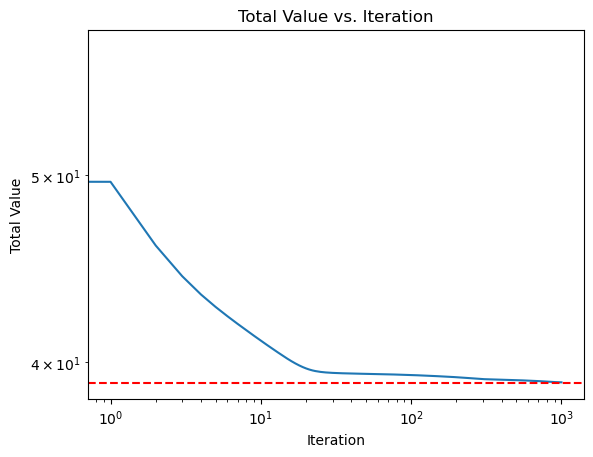

In [51]:
# Plot log values using log/log scale
import matplotlib.pyplot as plt

plt.plot(log)
plt.yscale("log")
plt.xscale("log")

# Add horizontal line at y = x_full
plt.axhline(y=p, color='red', linestyle='dashed')
plt.xlabel("Iteration")
plt.ylabel("Total Value")
plt.title("Total Value vs. Iteration")
plt.show()


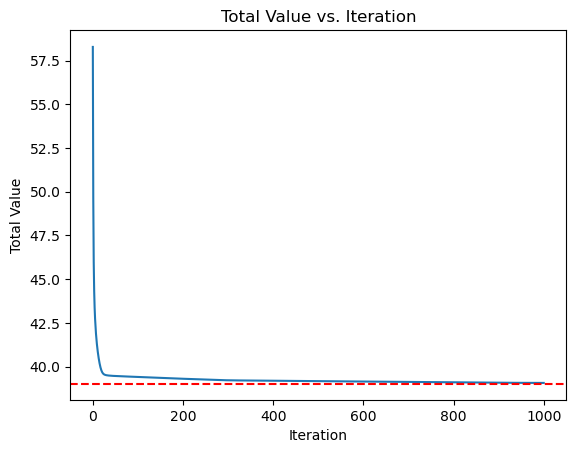

In [52]:

plt.plot(log)


# Add horizontal line at y = x_full
plt.axhline(y=p, color='red', linestyle='dashed')
plt.xlabel("Iteration")
plt.ylabel("Total Value")
plt.title("Total Value vs. Iteration")
plt.show()

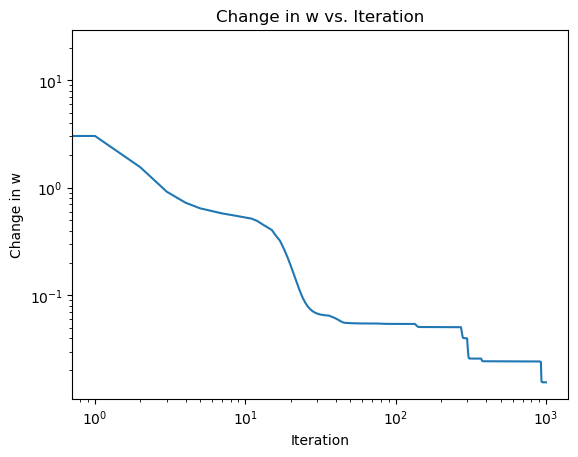

In [53]:
# Plot log_e values using log/log scale
plt.plot(log_e)
plt.yscale("log")
plt.xscale("log")

# Label axes
plt.xlabel("Iteration")
plt.ylabel("Change in w")
plt.title("Change in w vs. Iteration")
plt.show()

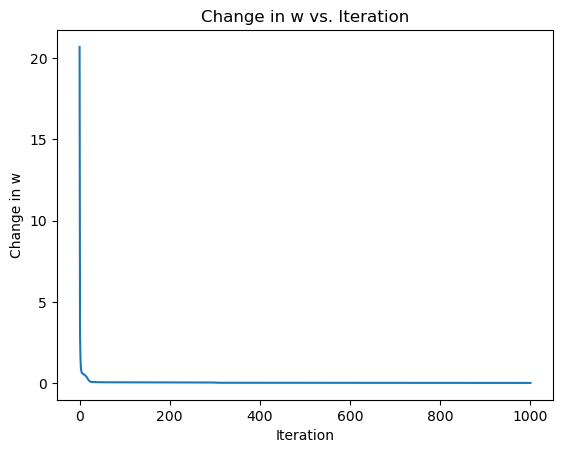

In [54]:
# Plot log_e values
plt.plot(log_e)

# Label axes
plt.xlabel("Iteration")
plt.ylabel("Change in w")
plt.title("Change in w vs. Iteration")
plt.show()

In [71]:

def serialAlgorithm(n, m, Q, V, WW, W, L, node_tgts, num_nodes_per_tgt, itrs=1001, gamma=0.5, verbose=False, logs=False):
    
    tgts = m[0]
    v0 = []
    vk = []
    log = []
    log_e = []
    for i in range(n):
        vi = 1/tgts*np.array(WW)*np.ones(m)
        v0.append(vi)
        vk.append(vi.copy())

    # Create variables/params/objs for the algorithm
    probs = [] # List of problems for each node
    all_x = [] # List of last x solutions for each node as params
    all_v = [] # List of last v solutions for each node as params
    all_w = []# List of variables for each node
    for i in range(n):
        w = cp.Variable(m)
        all_w.append(w)
        x = cp.Parameter(m)
        x.value = np.zeros(m)
        all_x.append(x)
        v = cp.Parameter(m)
        v.value = v0[i]
        all_v.append(v)
        y = v + sum(L[i,j]*all_x[j] for j in range(i)) + L[i,i]*w
        qq = np.ones(m)
        qq[node_tgts[i]] = Q[node_tgts[i]] # Only use the targets that are in the node
        weighted_weapons = cp.multiply(w, np.log(qq)) # (tgts, wpns)
        survival_probs = cp.exp(cp.sum(weighted_weapons, axis=1)) # (tgts,)
        VV = np.zeros(tgts)
        VV[node_tgts[i]] = V[node_tgts[i]]
        VV = VV/num_nodes_per_tgt
        obj = cp.Minimize(VV@survival_probs + .5*cp.sum_squares(w - y))
        cons = [w >= 0, cp.sum(w, axis=0) <= WW]
        probs.append(cp.Problem(obj, cons))

    # Run the algorithm
    for itr in range(itrs):
        #print("Iteration", itr)
        e = 0
        for i in range(n):
            probs[i].solve()
            # if itr % 500 == 0:
            #     print("Iteration", itr, "Node", i)
            #     print(all_w[i].value)
            e += np.linalg.norm(all_w[i].value - all_x[i].value)
            all_x[i].value = all_w[i].value
        log_e.append(e)
        for i in range(n):
            vk[i] -= gamma*sum(W[i,j]*all_x[j].value for j in range(n))
            all_v[i].value = vk[i]
        log.append(V@get_final_surv_prob(Q, all_x[0].value))
        # if itr % 500 == 0:
        #     print("v", vk)
    
    prob_val = V@wta.get_final_surv_prob(Q, all_w[0].value)
    if logs:
        return prob_val, all_w[0].value, log, log_e
    else:
        return prob_val, all_w[0].value


In [85]:
import time

In [86]:
t = time.time()
serial_p, serial_x, log, log_e = serialAlgorithm(n, m, q, V, WW, W, L, node_tgts, num_nodes_per_tgt, itrs=1001, gamma=0.5, verbose=False, logs=True)
print(time.time() - t)

48.837799310684204


In [73]:
serial_p

39.063384329909944

In [59]:
L_b = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [1.5, 0.5, 0, 0], [0.5,1.5,0,0]])
W_b = np.array([[1, 0, -1, 0], [0, 2, -0.5, -1.5], [-1, -0.5, 1.67218, -0.17218], [0,-1.5,-0.17218,1.67218]])

In [87]:
t = time.time()
m_serial_p, m_serial_x, m_log, m_log_e = serialAlgorithm(n, m, q, V, WW, W_b, L_b, node_tgts, num_nodes_per_tgt, itrs=1001, gamma=0.5, verbose=False, logs=True)
print(time.time() - t)

47.38671684265137


In [75]:
m_serial_p

39.02607684294745

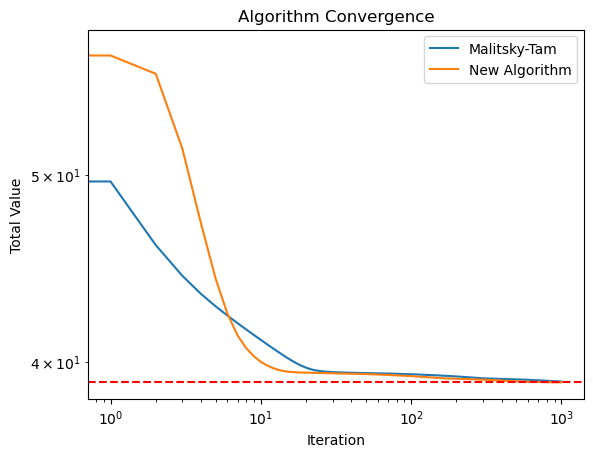

In [96]:
# Plot log values for both algs
plt.plot(log, label="Malitsky-Tam")
plt.plot(m_log, label="New Algorithm")

# Log scale 
plt.yscale("log")
plt.xscale("log")

# Add horizontal line at y = p
plt.axhline(y=p, color='red', linestyle='dashed')

# Label axes
plt.xlabel("Iteration")
plt.ylabel("Total Value")
plt.title("Algorithm Convergence")
plt.legend()
plt.show()

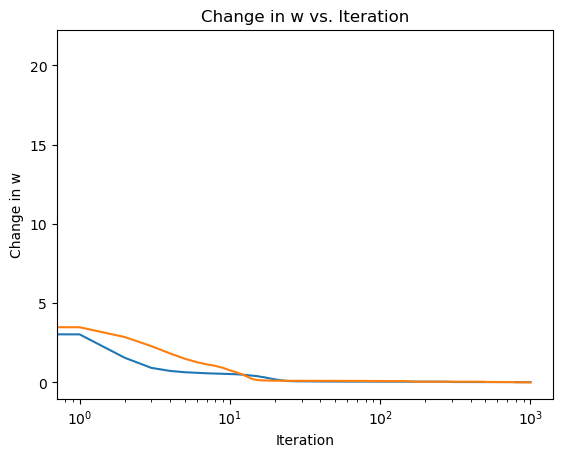

In [84]:
# Plot log_e values
plt.plot(log, label="Malitsky-Tam")
plt.plot(m_log, label="New Algorithm")

# log/log
plt.yscale("log")
plt.xscale("log")
# Label axes
plt.xlabel("Iteration")
plt.ylabel("Change in w")
plt.title("Change in w vs. Iteration")
plt.show()
